In [9]:
import pandas as pd 
import numpy as np
import pyarrow.parquet as pq
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import List 
import sklearn.preprocessing as preproc 

#from streamlit_searchbox import st_searchbox

In [12]:
trade_data_all_years = pq.ParquetDataset('../data/country_partner_sitcproduct4digit_year_2020.parquet').read_pandas().to_pandas()
trade_data_all_years

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
0,0,7,714,2020.0,0.0,3.878100e+04,0.752255,-0.210544,ABW,ARE,0579
1,1,7,714,2020.0,224345.0,6.891240e+06,-0.998556,-0.819045,AFG,ARE,0579
2,2,7,714,2020.0,0.0,6.106900e+04,-2.505675,-1.255388,AGO,ARE,0579
3,4,7,714,2020.0,10646.0,0.000000e+00,-0.214489,-0.017753,ALB,ARE,0579
4,8,7,714,2020.0,3140981.0,1.243100e+04,-0.224482,0.082711,ARG,ARE,0579
...,...,...,...,...,...,...,...,...,...,...,...
3979135,236,104,1437,2020.0,673855552.0,0.000000e+00,-1.373512,-1.288644,VEN,IND,ZZZZ
3979136,104,236,1437,2020.0,0.0,6.738556e+08,0.416269,2.959785,IND,VEN,ZZZZ
3979137,247,46,1437,2020.0,0.0,1.128212e+08,-0.860299,-1.028314,ZMB,COD,ZZZZ
3979138,46,247,1437,2020.0,112821248.0,0.000000e+00,-1.267712,-1.146566,COD,ZMB,ZZZZ


In [13]:
trade_data_all_years['minmax_import'] =  preproc.minmax_scale(trade_data_all_years[['import_value']])
trade_data_all_years['minmax_export'] =  preproc.minmax_scale(trade_data_all_years[['export_value']])
trade_data_all_years['standardized_import'] =  preproc.StandardScaler().fit_transform(trade_data_all_years[['import_value']])
trade_data_all_years['standardized_export'] =  preproc.StandardScaler().fit_transform(trade_data_all_years[['export_value']])

In [15]:
trade_data_all_years

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code,minmax_import,minmax_export,standardized_import,standardized_export
0,0,7,714,2020.0,0.0,3.878100e+04,0.752255,-0.210544,ABW,ARE,0579,3.689358e-07,0.000000e+00,-0.031136,-0.031422
1,1,7,714,2020.0,224345.0,6.891240e+06,-0.998556,-0.819045,AFG,ARE,0579,6.555852e-05,2.134264e-06,0.019373,-0.029768
2,2,7,714,2020.0,0.0,6.106900e+04,-2.505675,-1.255388,AGO,ARE,0579,5.809685e-07,0.000000e+00,-0.030972,-0.031422
3,4,7,714,2020.0,10646.0,0.000000e+00,-0.214489,-0.017753,ALB,ARE,0579,0.000000e+00,1.012787e-07,-0.031422,-0.031343
4,8,7,714,2020.0,3140981.0,1.243100e+04,-0.224482,0.082711,ARG,ARE,0579,1.182600e-07,2.988114e-05,-0.031330,-0.008270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3979135,236,104,1437,2020.0,673855552.0,0.000000e+00,-1.373512,-1.288644,VEN,IND,ZZZZ,0.000000e+00,6.410599e-03,-0.031422,4.935521
3979136,104,236,1437,2020.0,0.0,6.738556e+08,0.416269,2.959785,IND,VEN,ZZZZ,6.410599e-03,0.000000e+00,4.935521,-0.031422
3979137,247,46,1437,2020.0,0.0,1.128212e+08,-0.860299,-1.028314,ZMB,COD,ZZZZ,1.073304e-03,0.000000e+00,0.800176,-0.031422
3979138,46,247,1437,2020.0,112821248.0,0.000000e+00,-1.267712,-1.146566,COD,ZMB,ZZZZ,0.000000e+00,1.073304e-03,-0.031422,0.800176


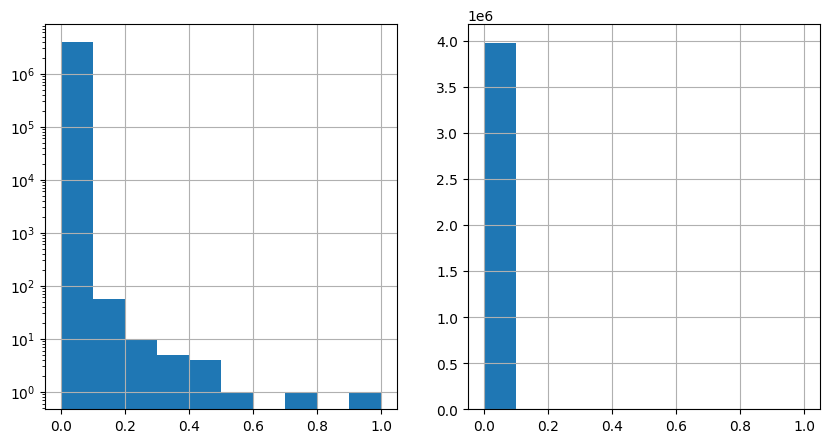

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
trade_data_all_years['minmax_import'].hist(ax=ax[0])
trade_data_all_years['minmax_export'].hist(ax=ax[1])
# Convert to log scale 
ax[0].set_yscale('log')

In [25]:
from sklearn import linear_model 
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preproc
trade_data_all_years.columns

Index(['location_id', 'partner_id', 'product_id', 'year', 'export_value',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'minmax_import', 'minmax_export',
       'standardized_import', 'standardized_export'],
      dtype='object')

In [30]:
features = ['import_value', 'export_value',  'minmax_import', 'minmax_export', 'standardized_import', 'standardized_export']
X = trade_data_all_years[features]
y = trade_data_all_years[['sitc_eci']]

In [31]:
X2 = preproc.PolynomialFeatures(include_bias=False).fit_transform(X)

In [32]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X, X2, y, test_size=0.2, random_state=42)

In [34]:
def evaluate_feature(X_train, X_test, y_train, y_test):
    
    """ Fit a linear model on the training data and evaluate it on the test data."""
    model = linear_model.LinearRegression().fit(X_train, y_train)
    r_score = model.score(X_test, y_test)
    return (model, r_score)

In [35]:
(m1, r1) = evaluate_feature(X1_train, X1_test, y_train, y_test)
(m2, r2) = evaluate_feature(X2_train, X2_test, y_train, y_test)
print("R squared for linear model: ", r1)
print("R squared for polynomial model: ", r2)

In [37]:
r1

0.0006789115106955457